# My neural network

In this project, you'll build your first neural network and use it to predict daily bike rental ridership. We've provided some of the code, but left the implementation of the neural network up to you (for the most part). At the very bottom of the notebook, you'll find some unit tests to check the correctness of your neural network. Be sure to run these before you submit your project.

After you've submitted this project, feel free to explore the data and the model more.



In [65]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights. Below, we've written the code to load and prepare the data. You'll learn more about this soon!

In [66]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [67]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column. You can see the first few rows of the data above.

Below is a plot showing the number of bike riders over the first 10 days in the data set. You can see the hourly rentals here. This data is pretty complicated! The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affecting the number of riders. You'll be trying to capture all this with your model.

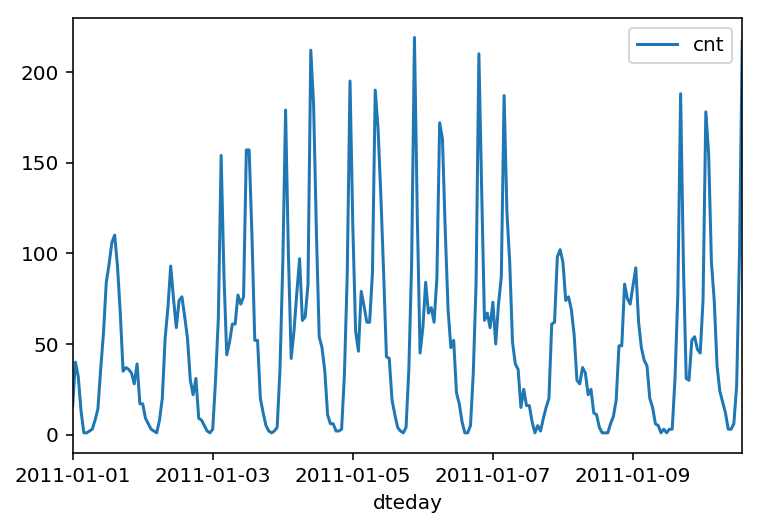

In [68]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
Here we have some categorical variables like season, weather, month. To include these in our model, we'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [69]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [70]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

We'll save the last 21 days of the data to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual number of riders.

In [71]:
# Save the last 21 days 
test_data = data[-21*24:]
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

We'll split the data into two sets, one for training and one for validating as the network is being trained. It's important to split the data randomly so all cases are represented in both sets.

In [72]:
np.random.seed(42) # seed the RNG to have consistent results
n_records = features.shape[0]
split = np.random.choice(features.index, 
                         size=int(n_records*0.8), 
                         replace=False)
train_features, train_targets = features.ix[split], targets.ix[split]
val_features, val_targets = features.drop(split), targets.drop(split)

### The standard sigmoid function

The sigmoid function (also called the standard logistic function) is a special case of the logistic function $f(x) = L / (1 + e^{-k(x - x_0)})$ where $L=1$, $k=1$, and $x_0=0$; thus $f(x) = 1 / (1 + e^{-x})$.  I've documented it here simply for reference.

In [73]:
def generate_logistic_function(L, k, x_0):
    """
    Generates a logistic function using the given parameters.
    
    This is overkill for this problem...because there
    is no need to use anything other than the standard
    logistic function.
    """
    return lambda x: (L / ( 1 + np.exp(-k * ( x - x_0))))

sigmoid = generate_logistic_function(L=1, k=1, x_0=0)


The sigmoid looks like this:

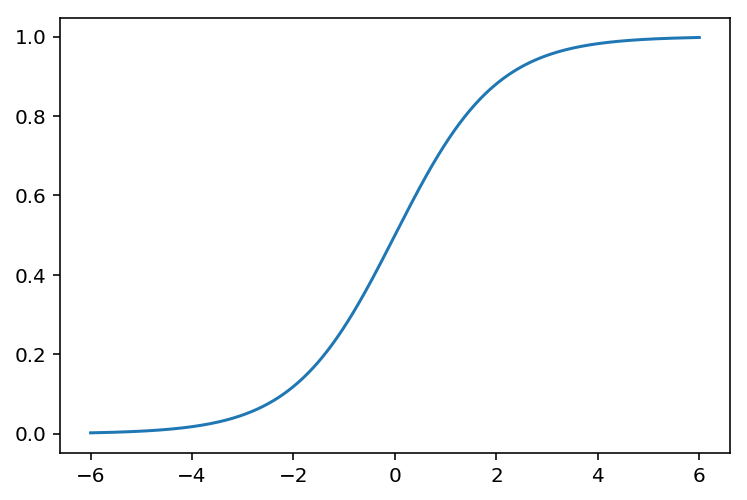

In [74]:
# plot the sigmoid
x = np.linspace(-6, 6, 1000)
y = sigmoid(x)
plt.plot(x, y)

Since the sigmoid will be called a lot, it is interesting to compare the performance of various implementations 

In [75]:
def hardcoded_array_sigmoid(x):
    # this will work correctly when x is an array/matrix
    return 1 / (1 + np.exp(-x))

def hardcoded_sigmoid(x):
    # this only works when x is a scalar
    return 1 / (1 + np.e**-x)

print("Performance using closure")
%timeit sigmoid(random.random())
print("Performance using hardcoded implementation")
%timeit hardcoded_sigmoid(random.random())
print("Performance using hardcoded implementation")
%timeit hardcoded_array_sigmoid(random.random())

Performance using closure
The slowest run took 16.39 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 3.42 µs per loop
Performance using hardcoded implementation
The slowest run took 13.44 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 717 ns per loop
Performance using hardcoded implementation
The slowest run took 16.20 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 2.34 µs per loop


In my experiments, the hardcoded version is usually about 1-1.5us faster.  Using `np.exp(-x)` is slower than using `np.e**-x` for this specific test case where the input is a scalar...but it's highly likely that using `np.exp` will be significantly faster when x is an array of many elements, maybe I will test the performance of that later. 

Your milage may vary.

### The NeuralNetwork implementation

Below is the two layer network, with a hidden layer and an output layer.  The hidden layer uses the sigmoid function (see above) for activations and the output layer is a passthrough (i.e. $f(x)=x$).

We work through each layer of our network calculating the outputs for each neuron. All of the outputs from one layer become inputs to the neurons on the next layer. This process is called *forward propagation*.

We use the weights to also propagate error backwards from the output back into the network to update our weights. This is called *backpropagation*.

Per the assignment, the following was done:
1. Implement the sigmoid function to use as the activation function. Set `self.activation_function` in `__init__` to your sigmoid function.
2. Implement the forward pass in the `train` method.
3. Implement the backpropagation algorithm in the `train` method, including calculating the output error.
4. Implement the forward pass in the `run` method.

In [76]:
class NeuralNetwork:
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        """
        Constructor for NeuralNetwork.
        
        input_nodes : int
            the number of input nodes
        hidden_nodes : int
            the number of hidden nodes
        output_nodes : int
            the number of output nodes
        learning_rate : float
            the learning rate
        """
        # Set number of nodes in input, hidden and output layers.
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # Initialize weights
        self.weights_input_to_hidden = np.random.normal(
            0.0,
            self.hidden_nodes**-0.5, 
            (self.hidden_nodes, self.input_nodes)
        )
        
        self.weights_hidden_to_output = np.random.normal(
            0.0,
            self.output_nodes**-0.5, 
            (self.output_nodes, self.hidden_nodes)
        )
        
        self.learning_rate = learning_rate

        # Hidden Layer activation function
        # f(h) = 1 / (1 + e^-x)  i.e. the sigmoid
        self.activation_function = lambda x: ( 1 / (1 + np.exp(-x)) )
        # f'(h) = f(h)*(1 - f(h)) when f = sigmoid
        self.activation_derivative = lambda x: ( x * ( 1 - x) )
        
        # Output layer activation function.  It's overkill to implement these for this use case,
        # but it ensure that the code is unambiguous and can be altered easily in the future
        # to use other activation functions
        # f(h) = h
        self.output_activation_function = lambda x: ( x )
        # f'(h) = 1
        self.output_derivative = lambda x: ( 1 )
    
    def train(self, inputs_list, targets_list):
        """
        Performs one pass of supervised training.
        
        inputs_list : list
            inputs for the network, must be of length equal to input_nodes
            
        targets_list :  list
            expected target for the given inputs
        """
        # Convert inputs list to 2d array as column vectors
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin = 2).T
        
        # Error check the length of the inputs and targets list
        if inputs.shape[0] != self.input_nodes:
            raise ValueError("inputs of incorrect length %s, must be length %s", inputs.shape[0], self.input_nodes)
        if targets.shape[0] != self.output_nodes:
            raise ValueError("targets_list of incorrect length %s, must be length %s", targets.shape[0], self.output_nodes)
            
        ### Forward pass ###
        # Note - this code is identical to what is executed in run() and could potentially be refactored
        
        # Hidden layer
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # Output layer
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)
        final_outputs = self.output_activation_function(final_inputs)
        
        ### Backward pass ###
        
        ## Output error
        # error = (y - y`)
        error = targets - final_outputs
        # d_o = (y - y`) * f'(W * a)
        output_errors = error * self.output_derivative(final_inputs)
        
        ## Hidden Layer Backpropagated error
        # d_o * w
        hidden_errors = np.dot(output_errors.T, self.weights_hidden_to_output).T # transpose now to make column vector
        # f`(h_j)
        hidden_grad = self.activation_derivative(hidden_outputs)
        
        ## Update the weights
        self.weights_hidden_to_output += self.learning_rate * np.dot(output_errors, hidden_outputs.T)
        self.weights_input_to_hidden += self.learning_rate * np.dot(hidden_errors * hidden_grad, inputs.T)
        
    def run(self, inputs_list):
        """
        Performs one pass of supervised training.
        
        inputs_list : list
            inputs for the network, must be of length equal to input_nodes
        """
        # Run a forward pass through the network
        inputs = np.array(inputs_list, ndmin=2).T
        
        # Error check the length of the inputs
        if inputs.shape[0] != self.input_nodes:
            raise ValueError("inputs of incorrect length %s, must be length %s", inputs.shape[0], self.input_nodes)
        
        #### Implement the forward pass here ####
        # Hidden Layer
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # Output layer
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs)
        final_outputs = self.output_activation_function(final_inputs)
        
        return final_outputs

In [77]:
def MSE(y, Y):
    """
    Calculate the mean-squared-error for two arrays
    
    y : list
        predictions list
    Y : list
        target list
    """
    return np.mean((y-Y)**2)

## Training the network

Implementation of training the network using a method know as Stochastic Gradient Descent (SGD). The idea is that for each training pass, you grab a random sample of the data instead of using the whole data set. You use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network faster.

In [78]:
def train_network(epochs, learning_rate, hidden_nodes, output_nodes):
    """
    Trains a two-layer neural network, using the globally provided
    train_features and val_features lists.
    
    epochs : int
        the number of epochs to train over
    learning_rate : float
        the learning rate
    hidden_nodes : int
        the number of hidden nodes
    output_nodes : int
        the number of output nodes
        
    Returns
    -------
    network : a NeuralNetwork
        the trained neural network
    
    losses : dictionary
        a 
    """
    global train_features, train_targets, val_features, val_targets
    
    N_i = train_features.shape[1]
    network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

    losses = {'train':[], 'validation':[]}
    for e in range(epochs):
        # Go through a random batch of 128 records from the training data set
        batch = np.random.choice(train_features.index, size=128)
        for record, target in zip(train_features.ix[batch].values, 
                                  train_targets.ix[batch]['cnt']):
            network.train(record, target)

        
        # Calculate losses for the training and test sets
        train_loss = MSE(network.run(train_features), train_targets['cnt'].values)
        val_loss = MSE(network.run(val_features), val_targets['cnt'].values)
        
        sys.stdout.write("\rProgress: " + str(100 * e/float(epochs))[:4]
                         + "% ... Training loss: "  + str(train_loss)[:5]
                         + " ... Validation loss: " + str(val_loss)[:5])
        losses['train'].append(train_loss)
        losses['validation'].append(val_loss)
            
    return network, losses

We implement two functions that will help us tune the hyperparameters, the `plot_losses` function allows us to observe how quickly and well the training converges.

The `check_and_plot_predictions` function uses the testing set to compare the predictions to the actual number of riders.

In [79]:
def plot_losses(losses, title=None):
    """
    losses : dictionary
        the losses dictionary calculated by train_network
        
    title : string, optional
        a title for the plot
    """
    plt.plot(losses['train'], label='Training loss')
    plt.plot(losses['validation'], label='Validation loss', linestyle=":")
    plt.legend()
    plt.ylim(ymax=0.5)
    if title:
        plt.title(title)

def check_and_plot_predictions(network, title=None):
    """
    network : a NeuralNetwork
        the network to use for the predictions
    
    title : string, optional
        a title for the plot
    """
    fig, ax = plt.subplots(figsize=(8,4))
    if title:
        plt.title(title)

    mean, std = scaled_features['cnt']
    _predictions = network.run(test_features)
    predictions = _predictions*std + mean
    ax.plot(predictions[0], label='Prediction')
    ax.plot((test_targets['cnt']*std + mean).values, label='Data')
    ax.set_xlim(right=len(predictions))
    ax.legend()

    dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
    dates = dates.apply(lambda d: d.strftime('%b %d'))
    ax.set_xticks(np.arange(len(dates))[12::24])
    _ = ax.set_xticklabels(dates[12::24], rotation=45)
    
    pred_loss = MSE(_predictions, test_targets['cnt'].values)
    return pred_loss

## Selecting the hyperparameters
Here we choose the hyperparameters for the network, train the network, and then check the predictions.

### Choose the number of epochs
This is the number of times the dataset will pass through the network, each time updating the weights. As the number of epochs increases, the network becomes better and better at predicting the targets in the training set. However, it can become too specific to the training set and will fail to generalize to the validation set. This is called overfitting. You'll need to choose enough epochs to train the network well but not too many or you'll be overfitting.

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. A good choice to start at is 0.1. If the network has problems fitting the data, try reducing the learning rate. Note that the lower the learning rate, the smaller the steps are in the weight updates and the longer it takes for the neural network to converge.

### Choose the number of hidden nodes
The more hidden nodes you have, the more accurate predictions the model will make. Try a few different numbers and see how it affects the performance. You can look at the losses dictionary for a metric of the network performance. If the number of hidden units is too low, then the model won't have enough space to learn and if it is too high there are too many options for the direction that the learning can take. The trick here is to find the right balance in number of hidden units you choose.

#### Default hyperparams

Progress: 99.9% ... Training loss: 0.064 ... Validation loss: 0.067

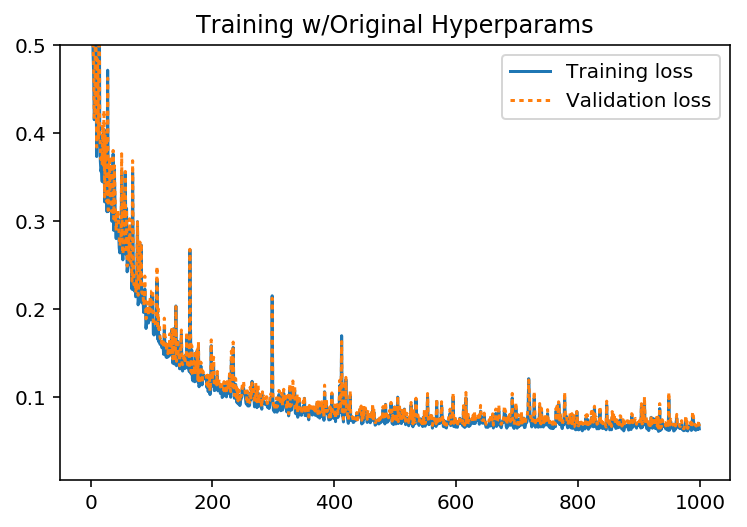

In [80]:
np.random.seed(42) # set the seed so we can have consistent comparisions 
network, losses = train_network(
    epochs = 1000,
    learning_rate = 0.1,
    hidden_nodes = 10,
    output_nodes = 1
)

plot_losses(losses, title="Training w/Original Hyperparams")

#### Increasing the number of hidden nodes

Given that we have 56 input nodes, we can probably increase the number of hidden nodes.

Progress: 99.9% ... Training loss: 0.066 ... Validation loss: 0.069

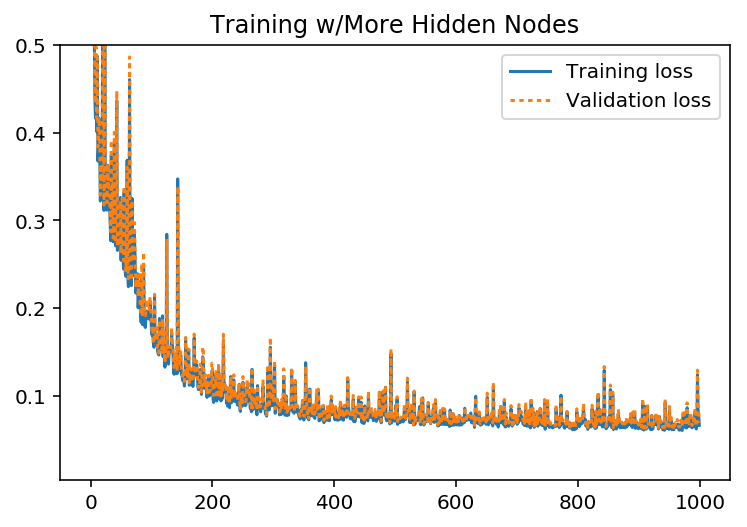

In [81]:
np.random.seed(42) # set the seed so we can have consistent comparisions 
network, losses = train_network(
    epochs = 1000,
    learning_rate = 0.1,
    hidden_nodes = 25,
    output_nodes = 1
)

plot_losses(losses, title="Training w/More Hidden Nodes")

That really didn't help, let's try increasing the number of epochs so that the network has more time to train.

#### Increasing the number of epochs

Progress: 99.9% ... Training loss: 0.057 ... Validation loss: 0.064

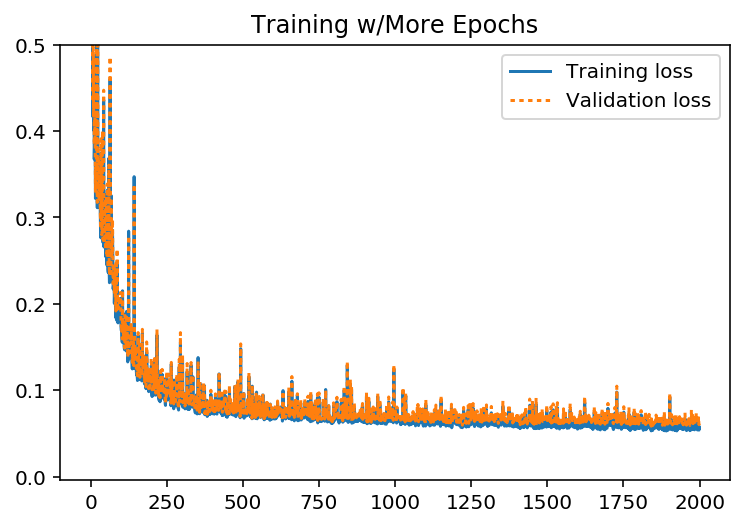

In [82]:
np.random.seed(42) # set the seed so we can have consistent comparisions 
network, losses = train_network(
    epochs = 2000,
    learning_rate = 0.1,
    hidden_nodes = 25,
    output_nodes = 1
)

plot_losses(losses, title="Training w/More Epochs")

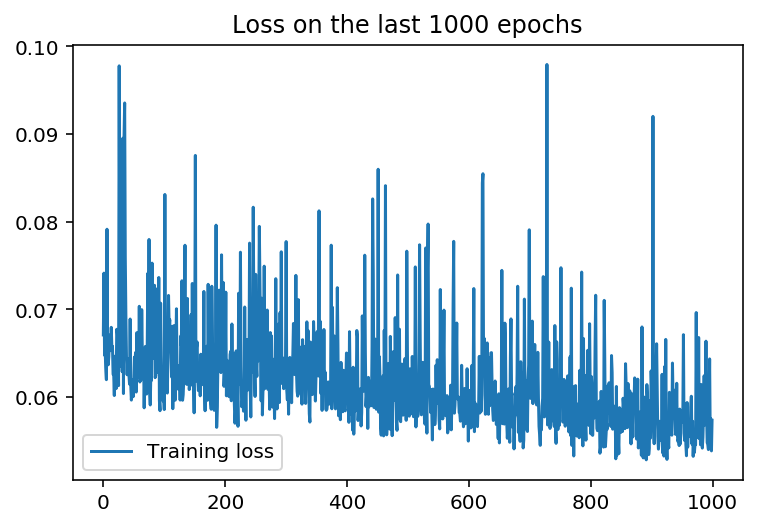

In [83]:
plt.plot(losses['train'][-1000:], label='Training loss')
plt.legend()
plt.title("Loss on the last 1000 epochs")

That improved the training loss, but the loss line still converges pretty quickly and is a bit noisy.  We can probably do better by lowering the learning rate and maybe bumping up the epochs a little.

#### decreasing learning rate

Progress: 99.9% ... Training loss: 0.053 ... Validation loss: 0.057

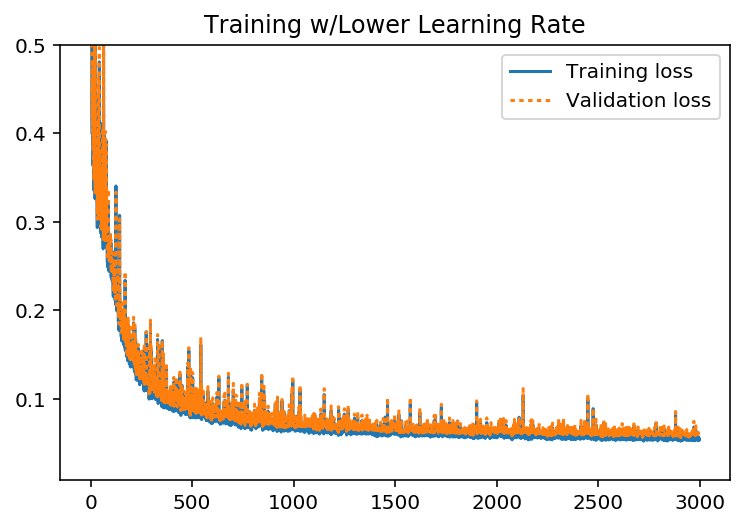

In [84]:
np.random.seed(42) # set the seed so we can have consistent comparisions 
network, losses = train_network(
    epochs = 3000,
    learning_rate = 0.05,
    hidden_nodes = 25,
    output_nodes = 1
)

plot_losses(losses, title="Training w/Lower Learning Rate")

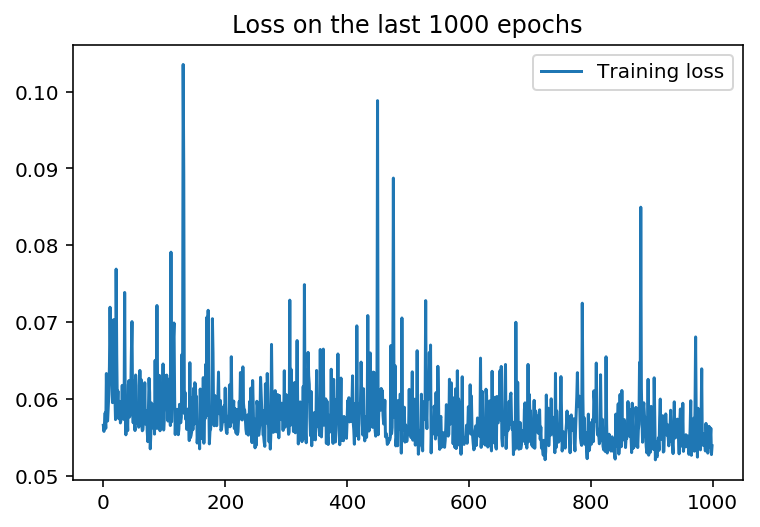

In [85]:
plt.plot(losses['train'][-1000:], label='Training loss')
plt.legend()
plt.title("Loss on the last 1000 epochs")

#### Final Hyper Parameters

Various parameter combinations were attempted, but a learning rate of 0.05, 25 hidden nodes, and 3000 epochs produced good results....let's see how it does:

Progress: 99.9% ... Training loss: 0.053 ... Validation loss: 0.057
Prediction loss: 0.1783


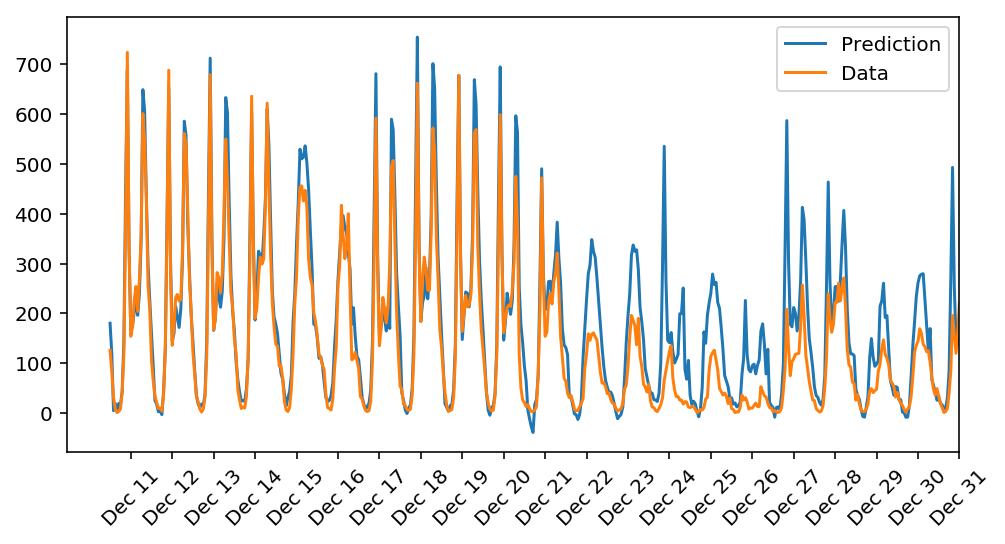

In [91]:
np.random.seed(42) # set the seed so we can have consistent comparisions 
network, losses = train_network(
    epochs = 3000,
    learning_rate = 0.05,
    hidden_nodes = 25,
    output_nodes = 1
)
loss = check_and_plot_predictions(network)
print("")
print("Prediction loss: {:.4f}".format(loss))

## Thinking about the results

The model appears to be fitting the data well for normal days (i.e. Dec 11th through the 20th), but the around the Christmas holiday it (i.e. Dec 22nd thorought the 26th) it performs noticibly worse.

A significant reason is that the training data set is too small to capture the behaviour of riders on and around holidays.  For example, there is _at most_ one Christmas day in the training data set depending on how the training set was selected.
The effect of this is very prominent on days, such as the 22nd, which look like normal days but due to their proximity to Chrismas can be treated like a holiday.  The training set has at most one December 22nd in it, so the network is unlikely to effectively learn that days like the Dec 22nd-24th are special.

The network also has no memory about how many riders rode the previous hour, if the training data included a column such as 'prev_cnt' the network would be able to potentially learn this relationship.

Finally, it should be noted that the training set is randomly selected, I observed the performance of the network changed drastically depending on what set of rows were selected for training.  Perhaps this is another indication that the training data set is deficent in some manner.

## Unit tests

In [89]:
import unittest

# Important: because the seed is set here, if you reorder tests they will start
# failing.  It would be better to seed within the TestCase::setUp() method
# so that the execution order of tests doesn't change the results (i.e running in
# parallel, only running one test, etc.).
np.random.seed(42) # the meaning of life
inputs = [0.5, -0.2, 0.1]
targets = [0.4]

class TestMethods(unittest.TestCase):
        
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path == 'Bike-Sharing-Dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    [ 0.22931895, -1.28754157]))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    [[-0.7128223, 0.22086344, -0.64139849],
                                     [-1.06444693, 1.06268915, -0.17280743]]))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        self.assertTrue(np.allclose(network.run(inputs), -0.97900982))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.007s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

### What's happening under the hood
Since this is a simple network, I found that manually calculating the forward and backwards propagation that is occurring during the unittest was a fun side-project

In [88]:
# This is manual calculation of what is occurring during the unit-test for train()
#
# These are the weights that are produced when np.random.seed(42) is used in the unittest
# for the 2nd instantition of the NeuralNetwork class
inputs = [ 0.5, -0.2, 0.1]
w_ih = [
  [-0.71617975, 0.22220642, -0.64206998],
  [-0.99864952,  1.03637018, -0.15964795]
]
w_ho = [
  [ 0.0675282, -1.42474819]
]
target = 0.4
learnrate = 0.5
# The sigmoid activation and it's derivative
sigmoid = lambda x: ( 1 / (1 + np.exp(-x)) )
sigmoid_der = lambda x: ( x * (1 - x) )
# The passthrough activation (for completenss)
passthrough = lambda x: ( x )
passthrough_der = lambda x: ( 1 )

###
# Forward pass
h1 = inputs[0] * w_ih[0][0] + inputs[1] * w_ih[0][1] + inputs[2] * w_ih[0][2]
h2 = inputs[0] * w_ih[1][0]  + inputs[1] * w_ih[1][1]  + inputs[2] * w_ih[1][2] 
print("Hidden Inputs", h1, h2)
a1 = sigmoid(h1)
a2 = sigmoid(h2)
print("Hidden Activations", a1, a2)
o  = a1 * w_ho[0][0] + a2 * w_ho[0][1]
print("Output Inputs", o)
oa = passthrough(o)
print("Output Activation", oa)

###
# Backpropagation
error = 0.4 - oa
print("Error", error)
# Error for output layer
error_gradient = error * passthrough_der(o)
print("Error gradients", error_gradient)
o_weight_del1 = learnrate * error_gradient * a1
o_weight_del2 = learnrate * error_gradient * a2
print("Weight deltas", o_weight_del1, o_weight_del2)

# Error for hidden layer
he1 = error_gradient * w_ho[0][0]
he2 = error_gradient * w_ho[0][1]
print("Hidden errors", he1, he2)
hg1 = he1 * sigmoid_der(a1)
hg2 = he2 * sigmoid_der(a2)
print("Hidden gradients", hg1, hg2)
h_weight_del = [
    [ learnrate * hg1 * inputs[0], learnrate * hg1 * inputs[1], learnrate * hg1 * inputs[2]],
    [ learnrate * hg2 * inputs[0], learnrate * hg2 * inputs[1], learnrate * hg2 * inputs[2]]
]
print("Hidden weight delta", h_weight_del)

# Update weights
w_ho[0][0] += o_weight_del1
w_ho[0][1] += o_weight_del2
print("Updated w_ho", w_ho)
w_ih[0][0] += h_weight_del[0][0]
w_ih[0][1] += h_weight_del[0][1]
w_ih[0][2] += h_weight_del[0][2]
w_ih[1][0] += h_weight_del[1][0]
w_ih[1][1] += h_weight_del[1][1]
w_ih[1][2] += h_weight_del[1][2]
print("Updated w_ih", w_ih)

Hidden Inputs -0.46673815700000004 -0.722563591
Hidden Activations 0.385388568092 0.326828712711
Output Inputs -0.439624020572
Output Activation -0.439624020572
Error 0.839624020572
Error gradients 0.839624020572
Weight deltas 0.161790749512 0.137206618903
Hidden errors 0.056698298786 -1.19625280359
Hidden gradients 0.0134297982989 -0.263189619239
Hidden weight delta [[0.0033574495747234869, -0.0013429798298893948, 0.00067148991494469742], [-0.065797404809638194, 0.026318961923855279, -0.013159480961927639]]
Updated w_ho [[0.2293189495117896, -1.2875415710974412]]
Updated w_ih [[-0.7128223004252765, 0.22086344017011059, -0.64139849008505534], [-1.0644469248096382, 1.0626891419238553, -0.17280743096192766]]
